# Versions

v1 pairwise

v2 ndcg

v3 map

v4 pairwise,w_rank

v5 pairwise SVER2

# validation

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
VER = 5
SVER = 2
IVER = 1
UVER = 1
WVER = 1
FEATURES = [
        'user', 'item_item_count', 'item_user_count', 
        'item_buy_ratio', 'user_user_count', 'user_item_count',
        'user_buy_ratio']

In [11]:
!nvidia-smi

Wed Jan 25 13:54:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    50W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
!pip install -q polars
import polars as pl
import pandas as pd, numpy as np
import pickle, glob, gc
from collections import Counter
import itertools
# multiprocessing 
import psutil
from multiprocessing import Pool
from sklearn.model_selection import GroupKFold
import psutil
import random
import os
N_CORES = psutil.cpu_count()     # Available CPU cores
print(f"N Cores : {N_CORES}")
from multiprocessing import Pool
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

seed_everything(42)

N Cores : 12


In [13]:
def merge_candidate(SVER,IVER,UVER,WVER,TYPE,MODE):
    candidates = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/suggest/{TYPE}/{MODE}_{TYPE}{SVER}.pqt')
    candidates['session'] = candidates.index
    candidates = candidates.set_index('session')
    item_features = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/item/{MODE}_item{IVER}.pqt')
    candidates = candidates.merge(item_features, left_on='item', right_index=True, how='left').fillna(-1)
    user_features = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/user/{MODE}_user{UVER}.pqt')
    candidates = candidates.merge(user_features, left_on='session', right_index=True, how='left').fillna(-1)
    candidates['user'] = candidates.index
    #w2v_features = pd.read_parquet(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/candidate/word2vec/{MODE}_{TYPE}{WVER}.pqt')
    #w2v_features['session'] = w2v_features.index
    #w2v_features['session'] = w2v_features['session'].astype(int)
    #w2v_features = w2v_features.drop_duplicates(subset=['item','session'])
    #w2v_features['w_rank'] = w2v_features.groupby('session').item.cumcount()+1
    #candidates = candidates.merge(w2v_features,on=['session','item'],how='left')
    candidates = candidates.set_index('user')
    return candidates

In [14]:
def merge_target(TYPE,candidates):
    tar = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/otto-validation/test_labels.parquet')
    tar = tar.loc[ tar['type']==TYPE ]
    aids = tar.ground_truth.explode().astype('int32').rename('item')
    tar = tar[['session']].astype('int32').rename({'session':'user'},axis=1)
    tar = tar.merge(aids, left_index=True, right_index=True, how='left')
    tar[TYPE] = 1
    candidates = candidates.merge(tar,on=['user','item'],how='left').fillna(0)
    return candidates

In [15]:
!pip install -q xgboost==1.6.2
import xgboost as xgb
from sklearn.model_selection import GroupKFold
from sklearn.metrics import recall_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.9/255.9 MB 7.0 MB/s eta 0:00:00


In [16]:
def train_xgb(candidates,TARGET):
    preds = np.zeros(len(candidates))
    skf = GroupKFold(n_splits=5)
    for fold,(train_idx, valid_idx) in enumerate(skf.split(candidates, candidates[TARGET], groups=candidates['user'] )):

        X_train = candidates.loc[train_idx, FEATURES]
        y_train = candidates.loc[train_idx, TARGET]
        X_valid = candidates.loc[valid_idx, FEATURES]
        y_valid = candidates.loc[valid_idx, TARGET]

        X_train = X_train.sort_values("user").reset_index(drop=True)
        X_valid = X_valid.sort_values("user").reset_index(drop=True)

        train_group = X_train.groupby('user').user.agg('count').values
        valid_group = X_valid.groupby('user').user.agg('count').values

        X_train = X_train.drop(["user"], axis=1)
        X_valid = X_valid.drop(["user"], axis=1)

        dtrain = xgb.DMatrix(X_train, y_train,group=train_group)
        dvalid = xgb.DMatrix(X_valid, y_valid,group=valid_group)

        xgb_parms = {
            'objective':'rank:pairwise', 
            'tree_method':'gpu_hist',
            'random_state': 42, 
            'learning_rate': 0.1,
            "colsample_bytree": 0.8, 
            'max_depth': 6,
        }
        model = xgb.train(xgb_parms, 
            dtrain=dtrain,
            evals=[(dtrain,'train'),(dvalid,'valid')],
            num_boost_round=1000,
            verbose_eval=500)
        preds[valid_idx] = model.predict(dvalid)
        model.save_model(f'XGB_fold{fold}_{TARGET}.xgb')
    predictions = candidates[['user','item']].copy()
    predictions['pred'] = preds
    predictions = predictions.sort_values(['user','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions['n'] = predictions.groupby('user').item.cumcount().astype('int8')
    predictions = predictions.loc[predictions.n<20]
    sub = predictions.groupby('user').item.apply(list)
    sub = sub.to_frame().reset_index()
    sub.item = sub.item.apply(lambda x: " ".join(map(str,x)))
    sub.columns = ['session','labels']
    sub.labels = sub.labels.apply(lambda x: [int(i) for i in x.split(' ')[:20]])
    test_labels = pd.read_parquet('/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/dataset/otto-validation/test_labels.parquet')
    test_labels = test_labels.loc[test_labels['type']==TARGET]
    test_labels = test_labels.merge(sub, how='left', on=['session'])
    test_labels['hits'] = test_labels.apply(lambda df: len(set(df.ground_truth).intersection(set(df.labels))), axis=1)
    test_labels['gt_count'] = test_labels.ground_truth.str.len().clip(0,20)
    recall = test_labels['hits'].sum() / test_labels['gt_count'].sum()
    print('{} Recall = {:.5f}'.format(TARGET,recall))

## clicks

In [17]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'clicks','val')
candidates = merge_target('clicks',candidates)
train_xgb(candidates,'clicks')
del candidates
_ = gc.collect()

[0]	train-map:0.64135	valid-map:0.64020
[500]	train-map:0.54363	valid-map:0.53826
[999]	train-map:0.54731	valid-map:0.53986
[0]	train-map:0.63337	valid-map:0.63386
[500]	train-map:0.54329	valid-map:0.53963
[999]	train-map:0.54705	valid-map:0.54094
[0]	train-map:0.63505	valid-map:0.63449
[500]	train-map:0.54307	valid-map:0.53725
[999]	train-map:0.54704	valid-map:0.53876
[0]	train-map:0.63428	valid-map:0.63481
[500]	train-map:0.54330	valid-map:0.53906
[999]	train-map:0.54683	valid-map:0.54041
[0]	train-map:0.63946	valid-map:0.63973
[500]	train-map:0.54313	valid-map:0.53949
[999]	train-map:0.54698	valid-map:0.54095
clicks Recall = 0.40336
CPU times: user 14min 25s, sys: 14.1 s, total: 14min 39s
Wall time: 12min 15s


## carts

In [18]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'carts','val')
candidates = merge_target('carts',candidates)
train_xgb(candidates,'carts')
del candidates
_ = gc.collect()

[0]	train-map:0.92149	valid-map:0.92141
[500]	train-map:0.90691	valid-map:0.90339
[999]	train-map:0.90890	valid-map:0.90368
[0]	train-map:0.91937	valid-map:0.91916
[500]	train-map:0.90704	valid-map:0.90326
[999]	train-map:0.90902	valid-map:0.90352
[0]	train-map:0.91865	valid-map:0.91759
[500]	train-map:0.90713	valid-map:0.90263
[999]	train-map:0.90903	valid-map:0.90285
[0]	train-map:0.91310	valid-map:0.91274
[500]	train-map:0.90695	valid-map:0.90362
[999]	train-map:0.90896	valid-map:0.90369
[0]	train-map:0.91965	valid-map:0.92006
[500]	train-map:0.90680	valid-map:0.90402
[999]	train-map:0.90880	valid-map:0.90431
carts Recall = 0.30908
CPU times: user 12min 24s, sys: 4.65 s, total: 12min 28s
Wall time: 11min 8s


## orders

In [19]:
%%time
candidates = merge_candidate(SVER,IVER,UVER,WVER,'orders','val')
candidates = merge_target('orders',candidates)
train_xgb(candidates,'orders')
del candidates
_ = gc.collect()

[0]	train-map:0.95095	valid-map:0.95109
[500]	train-map:0.94363	valid-map:0.94066
[999]	train-map:0.94527	valid-map:0.94078
[0]	train-map:0.95173	valid-map:0.95079
[500]	train-map:0.94386	valid-map:0.93986
[999]	train-map:0.94549	valid-map:0.93991
[0]	train-map:0.95247	valid-map:0.95186
[500]	train-map:0.94356	valid-map:0.94033
[999]	train-map:0.94517	valid-map:0.94040
[0]	train-map:0.95166	valid-map:0.95165
[500]	train-map:0.94360	valid-map:0.94062
[999]	train-map:0.94524	valid-map:0.94065
[0]	train-map:0.94883	valid-map:0.94924
[500]	train-map:0.94346	valid-map:0.94117
[999]	train-map:0.94502	valid-map:0.94123
orders Recall = 0.47704
CPU times: user 12min 16s, sys: 4.48 s, total: 12min 20s
Wall time: 11min 4s


# inference

In [20]:
def predict(test_candidates,TYPE):
    preds = np.zeros(len(test_candidates))
    test_candidates.reset_index(inplace=True)
    for fold in range(5):
        model = xgb.Booster()
        model.load_model(f'XGB_fold{fold}_{TYPE}.xgb')
        model.set_param({'predictor': 'gpu_predictor'})
        dtest = xgb.DMatrix(data=test_candidates[FEATURES].drop(["user"], axis=1))
        preds += model.predict(dtest)/5
    predictions = test_candidates[['user','item']].copy()
    predictions['pred'] = preds
    predictions = predictions.sort_values(['user','pred'], ascending=[True,False]).reset_index(drop=True)
    predictions['n'] = predictions.groupby('user').item.cumcount().astype('int8')
    predictions = predictions.loc[predictions.n<20]
    sub = predictions.groupby('user').item.apply(list)
    sub = sub.to_frame().reset_index()
    sub.item = sub.item.apply(lambda x: " ".join(map(str,x)))
    sub.columns = ['session_type','labels']
    sub.session_type = sub.session_type.astype('str')+ f'_{TYPE}'
    return sub

## clicks

In [21]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'clicks','test')
clicks_pred_df = predict(test_candidates,'clicks')
del test_candidates
_ = gc.collect()

CPU times: user 2min 50s, sys: 2.27 s, total: 2min 52s
Wall time: 1min 55s


## carts

In [22]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'carts','test')
carts_pred_df = predict(test_candidates,'carts')
del test_candidates
_ = gc.collect()

CPU times: user 2min 53s, sys: 2.33 s, total: 2min 55s
Wall time: 1min 53s


## orders

In [23]:
%%time
test_candidates = merge_candidate(SVER,IVER,UVER,WVER,'orders','test')
orders_pred_df = predict(test_candidates,'orders')
del test_candidates
_ = gc.collect()

CPU times: user 2min 50s, sys: 2.28 s, total: 2min 52s
Wall time: 1min 53s


# submission

In [24]:
pred_df = pd.concat([clicks_pred_df, orders_pred_df, carts_pred_df])
pred_df.columns = ["session_type", "labels"]
pred_df.to_csv(f"xgb{VER}.csv", index=False)
pred_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/kaggle/OTTO/submission/xgb{VER}.csv', index=False)

In [25]:
!pip install kaggle -q
import os
import json
f = open("/content/drive/MyDrive/Colab Notebooks/kaggle/kaggle.json", 'r')
json_data = json.load(f)
os.environ['KAGGLE_USERNAME'] = json_data['username']
os.environ['KAGGLE_KEY'] = json_data['key']

In [26]:
!kaggle competitions submit -c otto-recommender-system -f xgb5.csv -m ""

100% 779M/779M [00:13<00:00, 58.8MB/s]
Successfully submitted to OTTO – Multi-Objective Recommender System

In [27]:
import matplotlib.pyplot as plt
model = xgb.Booster()
model.load_model(f'XGB_fold1_clicks.xgb')

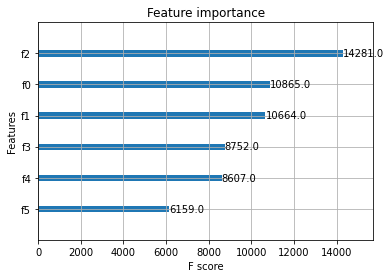

In [28]:
xgb.plot_importance(model)
plt.show()

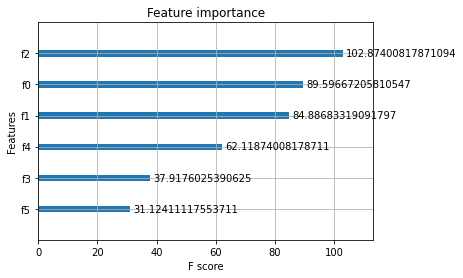

In [29]:
xgb.plot_importance(model,importance_type='gain')
plt.show()